# Problem 1

In [ ]:
import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# define transforms
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data',
                               train=True,
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data',
                               train=False,
                               transform=transforms)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 58.9MB/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 41.5MB/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 96.0MB/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.95MB/s]


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



## 1.1.1

Text(-10, -2, 'The label is 5')

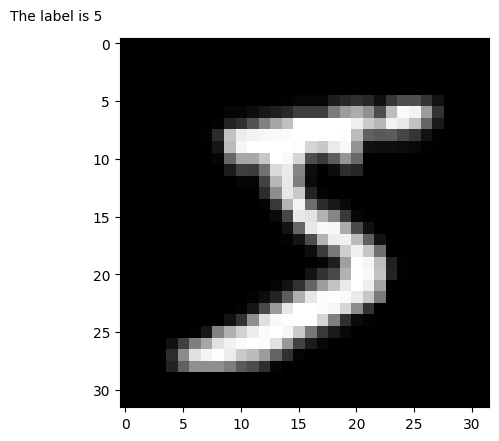

In [ ]:
plt.imshow(train_dataset[0][0].squeeze(), cmap='gray')
plt.text(-10, -2, 'The label is ' + str(train_dataset[0][1]))

In [ ]:
# hyper parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

## 1.1.2

In [ ]:
# define the data loaders
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

## 1.1.3

In [ ]:
def train(train_loader, model, criterion, optimizer):
    '''
    Train one epoch.
    '''
    model.train()
    running_loss = 0

    for X, y_true in train_loader:
      optimizer.zero_grad()

      # Forward pass
      y_hat, _ = model(X)
      loss = criterion(y_hat, y_true)
      running_loss += loss.item() * X.size(0)

      # Backward pass
      loss.backward()
      optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

## 1.1.4

In [ ]:
def validate(valid_loader, model, criterion):
    '''
    Function for the validation step of the training loop.
    Returns the model and the loss on the test set.
    '''

    model.eval()
    running_loss = 0

    for X, y_true in valid_loader:

        # Forward pass and record loss
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)

    return model, epoch_loss

In [ ]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, print_every=1):
    '''
    Function defining the entire training loop
    '''

    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader,)
            train_accs.append(train_acc)
            valid_acc = get_accuracy(model, valid_loader)
            valid_accs.append(valid_acc)

            print(f'{datetime.now().time().replace(microsecond=0)} '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    performance = {
        'train_losses':train_losses,
        'valid_losses': valid_losses,
        'train_acc': train_accs,
        'valid_acc':valid_accs
    }

    return model, optimizer, performance

## 1.1.5

In [ ]:
def get_accuracy(model, data_loader):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''

    correct_pred = 0
    n = 0

    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:
          y_prob = model(X)[1]
          _, predicted_labels = torch.max(y_prob, 1)

          n += y_true.size(0)
          correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n



def plot_performance(performance):
    '''
    Function for plotting training and validation losses
    '''

    # temporarily change the style of the plots to seaborn
    plt.style.use('seaborn-v0_8-bright')

    fig, ax = plt.subplots(1, 2, figsize = (16, 4.5))
    for key, value in performance.items():
        if 'loss' in key:
            ax[0].plot(value, label=key)
        else:
            ax[1].plot(value, label=key)
    ax[0].set(title="Loss  over epochs",
            xlabel='Epoch',
            ylabel='Loss')
    ax[1].set(title="accuracy over epochs",
            xlabel='Epoch',
            ylabel='Loss')
    ax[0].legend()
    ax[1].legend()
    plt.show()

    # change the plot style to default
    plt.style.use('default')

## 1.2.1

In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,6, kernel_size=5, stride=1, padding=0),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))

        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, n_classes)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

## 1.2.2

In [ ]:
class MLP(nn.Module):

    def __init__(self, layers):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))

        self.activation = nn.Tanh()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for i in range(len(self.layers) - 1):
            x = self.layers[i](x)
            x = self.activation(x)

        logits = self.layers[-1](x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

## 1.3.1

In [ ]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [ ]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [ ]:
model, optimizer, performance_1 = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS)

04:47:22 Epoch: 0	Train loss: 0.1745	Valid loss: 0.0660	Train accuracy: 98.10	Valid accuracy: 97.84
04:48:14 Epoch: 1	Train loss: 0.0559	Valid loss: 0.0425	Train accuracy: 98.97	Valid accuracy: 98.57
04:49:05 Epoch: 2	Train loss: 0.0398	Valid loss: 0.0452	Train accuracy: 99.23	Valid accuracy: 98.57
04:49:57 Epoch: 3	Train loss: 0.0299	Valid loss: 0.0401	Train accuracy: 99.43	Valid accuracy: 98.71
04:50:49 Epoch: 4	Train loss: 0.0241	Valid loss: 0.0451	Train accuracy: 99.36	Valid accuracy: 98.60
04:51:42 Epoch: 5	Train loss: 0.0199	Valid loss: 0.0362	Train accuracy: 99.68	Valid accuracy: 98.79
04:52:36 Epoch: 6	Train loss: 0.0166	Valid loss: 0.0386	Train accuracy: 99.69	Valid accuracy: 98.92
04:53:27 Epoch: 7	Train loss: 0.0155	Valid loss: 0.0488	Train accuracy: 99.67	Valid accuracy: 98.62
04:54:20 Epoch: 8	Train loss: 0.0113	Valid loss: 0.0447	Train accuracy: 99.59	Valid accuracy: 98.73
04:55:12 Epoch: 9	Train loss: 0.0125	Valid loss: 0.0489	Train accuracy: 99.64	Valid accuracy: 98.64


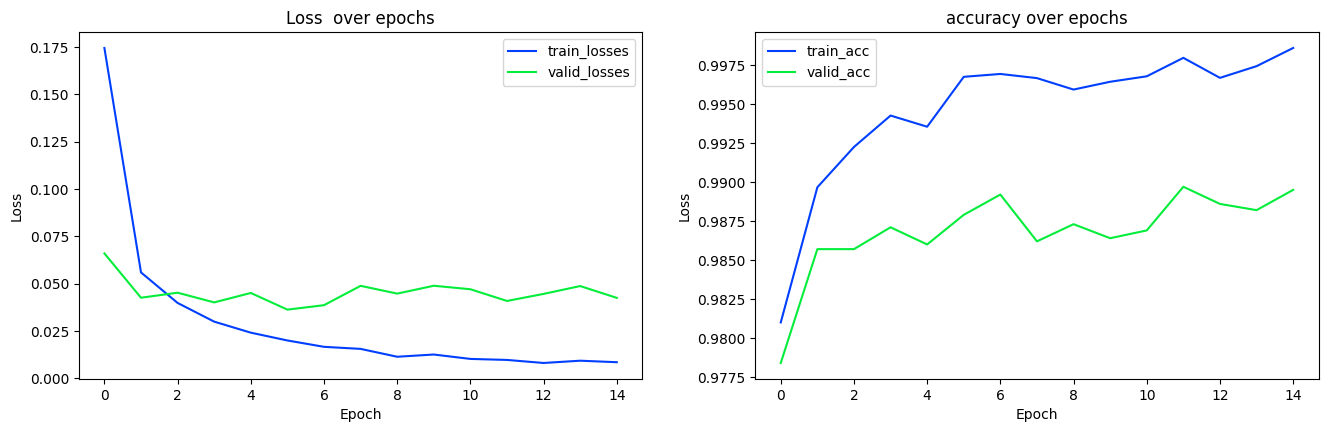

In [ ]:
plot_performance(performance_1)

## 1.3.2

In [ ]:
torch.manual_seed(RANDOM_SEED)
layers = [1024, 256, 64, 16, N_CLASSES]
model = MLP(layers)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=10, bias=True)
  )
  (activation): Tanh()
)


In [ ]:
model, optimizer, performance_2 = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS)

04:21:32 Epoch: 0	Train loss: 0.3575	Valid loss: 0.1636	Train accuracy: 95.61	Valid accuracy: 95.23
04:22:05 Epoch: 1	Train loss: 0.1307	Valid loss: 0.1195	Train accuracy: 97.27	Valid accuracy: 96.38
04:22:40 Epoch: 2	Train loss: 0.0927	Valid loss: 0.1016	Train accuracy: 97.93	Valid accuracy: 96.97
04:23:16 Epoch: 3	Train loss: 0.0725	Valid loss: 0.0896	Train accuracy: 98.21	Valid accuracy: 97.26
04:23:51 Epoch: 4	Train loss: 0.0592	Valid loss: 0.0844	Train accuracy: 98.41	Valid accuracy: 97.45
04:24:25 Epoch: 5	Train loss: 0.0514	Valid loss: 0.0973	Train accuracy: 98.33	Valid accuracy: 97.14
04:24:58 Epoch: 6	Train loss: 0.0433	Valid loss: 0.0845	Train accuracy: 98.80	Valid accuracy: 97.35
04:25:32 Epoch: 7	Train loss: 0.0380	Valid loss: 0.0728	Train accuracy: 99.25	Valid accuracy: 97.79
04:26:06 Epoch: 8	Train loss: 0.0328	Valid loss: 0.0822	Train accuracy: 99.25	Valid accuracy: 97.76
04:26:40 Epoch: 9	Train loss: 0.0324	Valid loss: 0.0801	Train accuracy: 99.42	Valid accuracy: 97.82


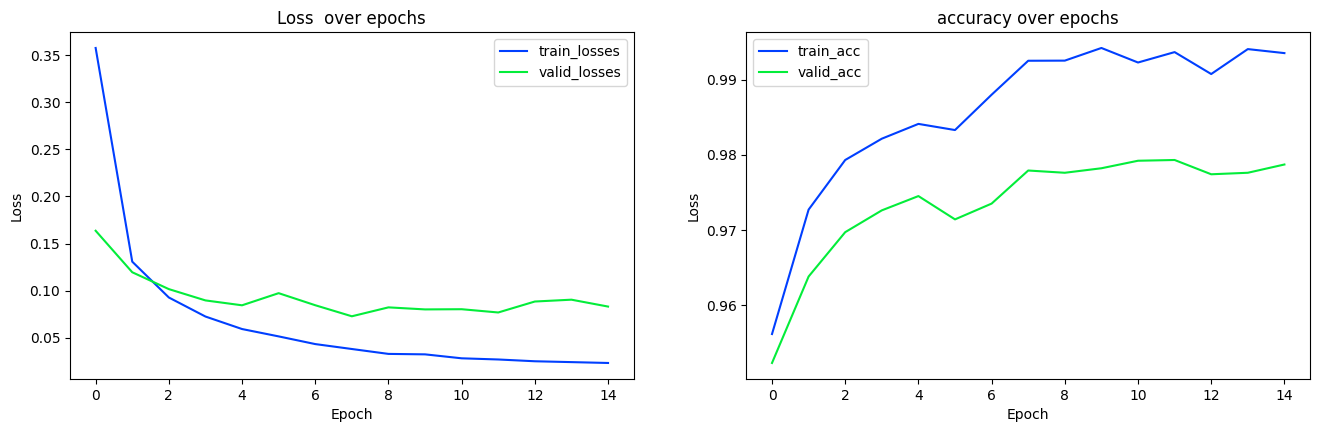

In [ ]:
plot_performance(performance_2)

#1.4 Comparison of two models

What is the number of trainable parameters of LeNet?

Conv1: (1 * 5 * 5 * 6) + 6 = 156

Conv2: (6 * 5 * 5 * 16) + 16 = 2416

FC1: (400 * 120) + 120 = 48120

FC2: (120 * 84) + 84 = 10164

FC3: (84 * 10) + 10 = 850  

Total parameters: 61706

What is the number of trainable parameters of MLP?

Layer 1: (1024 * 256) + 256 = 262400

Layer 2: (256 * 64) + 64 = 16448

Layer 3: (64 * 16) + 16 = 1040

Layer 4: (16 * 10) + 10 = 170

Total parameters: 280058




Which model has better performance in terms of prediction accuracy on the test data? Give a reason why
this model works better than the other.

In [ ]:
print('LeNet Accuracy: ', max(performance_1['valid_acc'])*100)
print('MLP Accuracy: ', max(performance_2['valid_acc'])*100)

LeNet Accuracy:  tensor(98.9700)
MLP Accuracy:  tensor(97.9300)


The first model performs better. This is because LeNet use Convolutional Neural Networks(CNNs) which are better are capturign the intricacies of image data.
MLP is a fully connected neural network and does not take advantage of the spatial structure of image data.

